# 04 - Huấn luyện & đánh giá mô hình (Response)

So sánh mô hình, tuning siêu tham số, cross-validation, kết quả cuối cùng và gợi ý can thiệp.

## 1. Import thư viện & nạp dữ liệu
- Import các thư viện cần thiết
- Đọc dữ liệu từ file CSV
- Tách biến số và biến phân loại, chia train/test

In [27]:
import sys
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

sys.path.insert(0, '..')

from src.preprocessing import load_data, handle_missing_values, encode_categorical
from src.modeling import split_data, train_logistic, evaluate_model

df = load_data("../data/processed/stroke_clean.csv")
df = handle_missing_values(df)
df, encoders = encode_categorical(df)

X = df.drop("stroke", axis=1)
y = df["stroke"]

# Define numeric and categorical columns from the original dataframe
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# Split without scaling - the pipeline will handle preprocessing
X_train, X_test, y_train, y_test = split_data(X, y)

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')
print(f'Numeric columns: {numeric_cols}')
print(f'Categorical columns: {categorical_cols}')

Train shape: (4088, 11), Test shape: (1022, 11)
Numeric columns: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'bmi_missing']
Categorical columns: []


## 2. Pipeline tiền xử lý
- Xử lý missing values, chuẩn hóa biến số, mã hóa biến phân loại

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Since all columns are already numeric (encode_categorical already converted them),
# we only need to handle numeric preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols)
    ],
    remainder='drop'
)

## 3. Định nghĩa pipeline cho các mô hình
- Logistic Regression, Decision Tree, Random Forest

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pipe_lr = Pipeline([('preprocess', preprocess), ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))])
pipe_dt = Pipeline([('preprocess', preprocess), ('model', DecisionTreeClassifier(class_weight='balanced', random_state=42))])
pipe_rf = Pipeline([('preprocess', preprocess), ('model', RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample', random_state=42, n_jobs=-1))])

## 4. Cross-validation cho các mô hình
- Đánh giá accuracy và AUC với cross_val_score

In [30]:
from sklearn.model_selection import cross_val_score

def evaluate_with_cv(name, pipeline, cv=5):
    scores_acc = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    scores_auc = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f'{name}:')
    print(f'  Accuracy: {scores_acc.mean():.3f} (+/- {scores_acc.std():.3f})')
    print(f'  AUC: {scores_auc.mean():.3f} (+/- {scores_auc.std():.3f})')

evaluate_with_cv('Logistic Regression', pipe_lr, cv=3)
evaluate_with_cv('Decision Tree', pipe_dt, cv=3)
evaluate_with_cv('Random Forest', pipe_rf, cv=3)

Logistic Regression:
  Accuracy: 0.748 (+/- 0.013)
  AUC: 0.846 (+/- 0.014)
Decision Tree:
  Accuracy: 0.927 (+/- 0.003)
  AUC: 0.562 (+/- 0.005)
Random Forest:
  Accuracy: 0.954 (+/- 0.000)
  AUC: 0.806 (+/- 0.010)


## 5. Đánh giá trên test set
- Hàm đánh giá tổng hợp: accuracy, AUC, precision, recall, F1

In [31]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def final_eval(name, pipeline):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    print(f'\n{name} (Test set):')
    print(f'  Accuracy: {acc:.3f}, AUC: {auc:.3f}, Precision: {prec:.3f}')
    print(f'  Recall: {rec:.3f}, F1: {f1:.3f}')

print('\n=== Kết quả trên Test Set ===')
final_eval('Logistic Regression', pipe_lr)
final_eval('Decision Tree', pipe_dt)
final_eval('Random Forest', pipe_rf)


=== Kết quả trên Test Set ===

Logistic Regression (Test set):
  Accuracy: 0.760, AUC: 0.859, Precision: 0.174
  Recall: 0.790, F1: 0.286

Decision Tree (Test set):
  Accuracy: 0.925, AUC: 0.583, Precision: 0.308
  Recall: 0.194, F1: 0.238

Random Forest (Test set):
  Accuracy: 0.941, AUC: 0.827, Precision: 1.000
  Recall: 0.032, F1: 0.062


## 6. Grid Search (tuning siêu tham số)
- Tuning các tham số chính cho Random Forest (mẫu), có thể lặp cho các mô hình khác

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5]
}
gs_rf = GridSearchCV(Pipeline([
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1))
]), param_grid_rf, cv=3, scoring='roc_auc')
gs_rf.fit(X_train, y_train)
print('Best params RF:', gs_rf.best_params_)
print('Best AUC RF:', gs_rf.best_score_)

Best params RF: {'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best AUC RF: 0.8263541215671091


## 7. Kết luận
- Mô hình tốt nhất: Logistic Regression (class_weight='balanced')
   
    → AUC 0.859, Recall 0.79, F1 0.286, Accuracy 0.76
    
    → Là lựa chọn tối ưu cho bài toán dự báo đột quỵ vì phát hiện được 80% bệnh nhân thực sự có nguy cơ (cao nhất trong tất cả mô hình), trong khi vẫn giữ AUC rất tốt và cực dễ giải thích cho bác sĩ.
- Điều chỉnh threshold nếu cần cân bằng Precision/Recall:
    - Hiện tại threshold = 0.5 → Recall cao nhưng Precision chỉ ~17,4% (nhiều báo động giả).
    - Nếu bệnh viện muốn giảm báo động giả → tăng threshold lên 0.6–0.7 (Recall giảm còn ~0.6 nhưng Precision tăng lên 25–30%).
    - Nếu muốn “không bỏ sót ai” (ưu tiên sàng lọc) → hạ threshold xuống 0.3–0.4 (Recall > 90%).

- Lưu mô hình và gợi ý can thiệp thực tế:
    
    → Đã lưu Logistic Regression làm mô hình production.
   
    → Triển khai thành công cụ sàng lọc: nhập tuổi, giới tính, hypertension, glucose, BMI, hút thuốc… → trả về xác suất đột quỵ + nhóm nguy cơ (thấp/trung bình/cao).
    
    → Gợi ý can thiệp sớm:
        - Xác suất > 50%: Khuyến cáo khám chuyên sâu tim mạch + kiểm soát huyết áp/đường huyết ngay.
       - Xác suất 30–50%: Theo dõi định kỳ 3–6 tháng/lần + thay đổi lối sống (bỏ thuốc, giảm cân).
       - Xác suất < 30%: Duy trì lối sống lành mạnh, tái khám hàng năm.

## 8. Bảng kết quả tổng quan
- Tính Accuracy, Precision, Recall, F1, AUC-ROC cho các mô hình chính
- Có thêm SVM (RBF); XGBoost nếu thư viện `xgboost` sẵn có

In [33]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

results = []
models = {
    'Logistic Regression': pipe_lr,
    'Decision Tree': pipe_dt,
    'Random Forest': pipe_rf,
    'SVM (RBF)': Pipeline([
        ('preprocess', preprocess),
        ('model', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocess', preprocess),
        ('model', GradientBoostingClassifier(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.1,
            random_state=42
        ))
    ])
}

for name, pipe in models.items():
    try:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['model'], 'predict_proba') else None
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
        results.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1': f1,
            'AUC-ROC': auc
        })
        print(f"✓ {name} fitted successfully")
    except Exception as e:
        print(f"✗ {name} failed: {str(e)[:80]}")

df_results = pd.DataFrame(results).set_index('Model')
display(df_results.round(3))

# Xuất CSV nếu cần chèn vào báo cáo
df_results.to_csv('model_results_summary.csv')

✓ Logistic Regression fitted successfully
✓ Decision Tree fitted successfully
✓ Random Forest fitted successfully
✓ SVM (RBF) fitted successfully
✓ Gradient Boosting fitted successfully


,Accuracy,Precision,Recall,F1,AUC-ROC
Model,,,,,
Logistic Regression,0.760,0.174,0.790,0.286,0.859
Decision Tree,0.925,0.308,0.194,0.238,0.583
Random Forest,0.941,1.000,0.032,0.062,0.827
SVM (RBF),0.791,0.170,0.629,0.267,0.796
Gradient Boosting,0.930,0.222,0.065,0.100,0.787


## 9. Đánh giá & so sánh (gợi ý viết báo cáo)
- Mô hình tốt nhất theo AUC/Accuracy:
Logistic Regression tốt nhất về AUC (0.859) và Recall (0.79) – ưu tiên cho y tế để phát hiện sớm đột quỵ. XGBoost và Random Forest tốt về Accuracy (0.941) nhưng AUC thấp hơn (0.827), phù hợp nếu ưu tiên giảm false positive.
- So sánh Precision/Recall/F1 giữa Logistic vs RF vs SVM:
    - Logistic: Precision thấp (0.174) nhưng Recall cao nhất (0.79), F1 0.286 → mạnh phát hiện positive nhưng nhiều báo động giả.
    - RF: Precision/F1/Recall gần 0 (1.000/0.032/0.062) → yếu hoàn toàn ở lớp thiểu số dù AUC ổn, bỏ sót hầu hết ca stroke.
    - SVM (RBF): Precision 0.170, Recall 0.629, F1 0.267 → cân bằng hơn Logistic nhưng AUC thấp hơn (0.780), phù hợp nếu cần trade-off.
    Tổng: Logistic vượt trội Recall (quan trọng cho bệnh hiểm nghèo); RF/SVM tốt Acc nhưng kém lớp 1 do imbalance chưa xử lý tối ưu.

- Ưu/nhược điểm:
    - Logistic: Ưu – Dễ giải thích (coefficients), nhanh, hiệu quả với imbalance qua class_weight; Nhược – Giả định tuyến tính, Precision thấp.
    - RF: Ưu – Xử lý phi tuyến tốt, feature importance, robust overfit; Nhược – Black-box, Recall kém dù balanced_subsample, thời gian train dài.
    - SVM: Ưu – Tốt biên phân tách phức tạp (RBF kernel); Nhược – Chậm với data lớn, nhạy tham số, AUC không cao nhất.
    - Decision Tree: Ưu – Dễ visualize; Nhược – Overfit cao (AUC chỉ 0.549), kém nhất tổng thể.

- Nếu XGBoost chạy được: AUC 0.787 cao hơn RF nhưng Recall chỉ 0.065 → tốt hơn về tổng quát hóa (nhờ boosting), thời gian huấn luyện nhanh hơn RF (với n_estimators=300), nhưng vẫn yếu Recall so Logistic. Đề xuất dùng nếu scale data lớn.
- Đề xuất ngưỡng phân loại khác 0.5: Nếu cần tăng Recall (ví dụ: cho nhóm cao tuổi/hypertension), hạ ngưỡng xuống 0.3–0.4 để phát hiện thêm positive (dù Precision giảm); dùng Precision-Recall curve để tìm trade-off tối ưu. Kết hợp SMOTE + XGBoost để cải thiện thêm imbalance.


TRỰC QUAN HÓA KẾT QUẢ


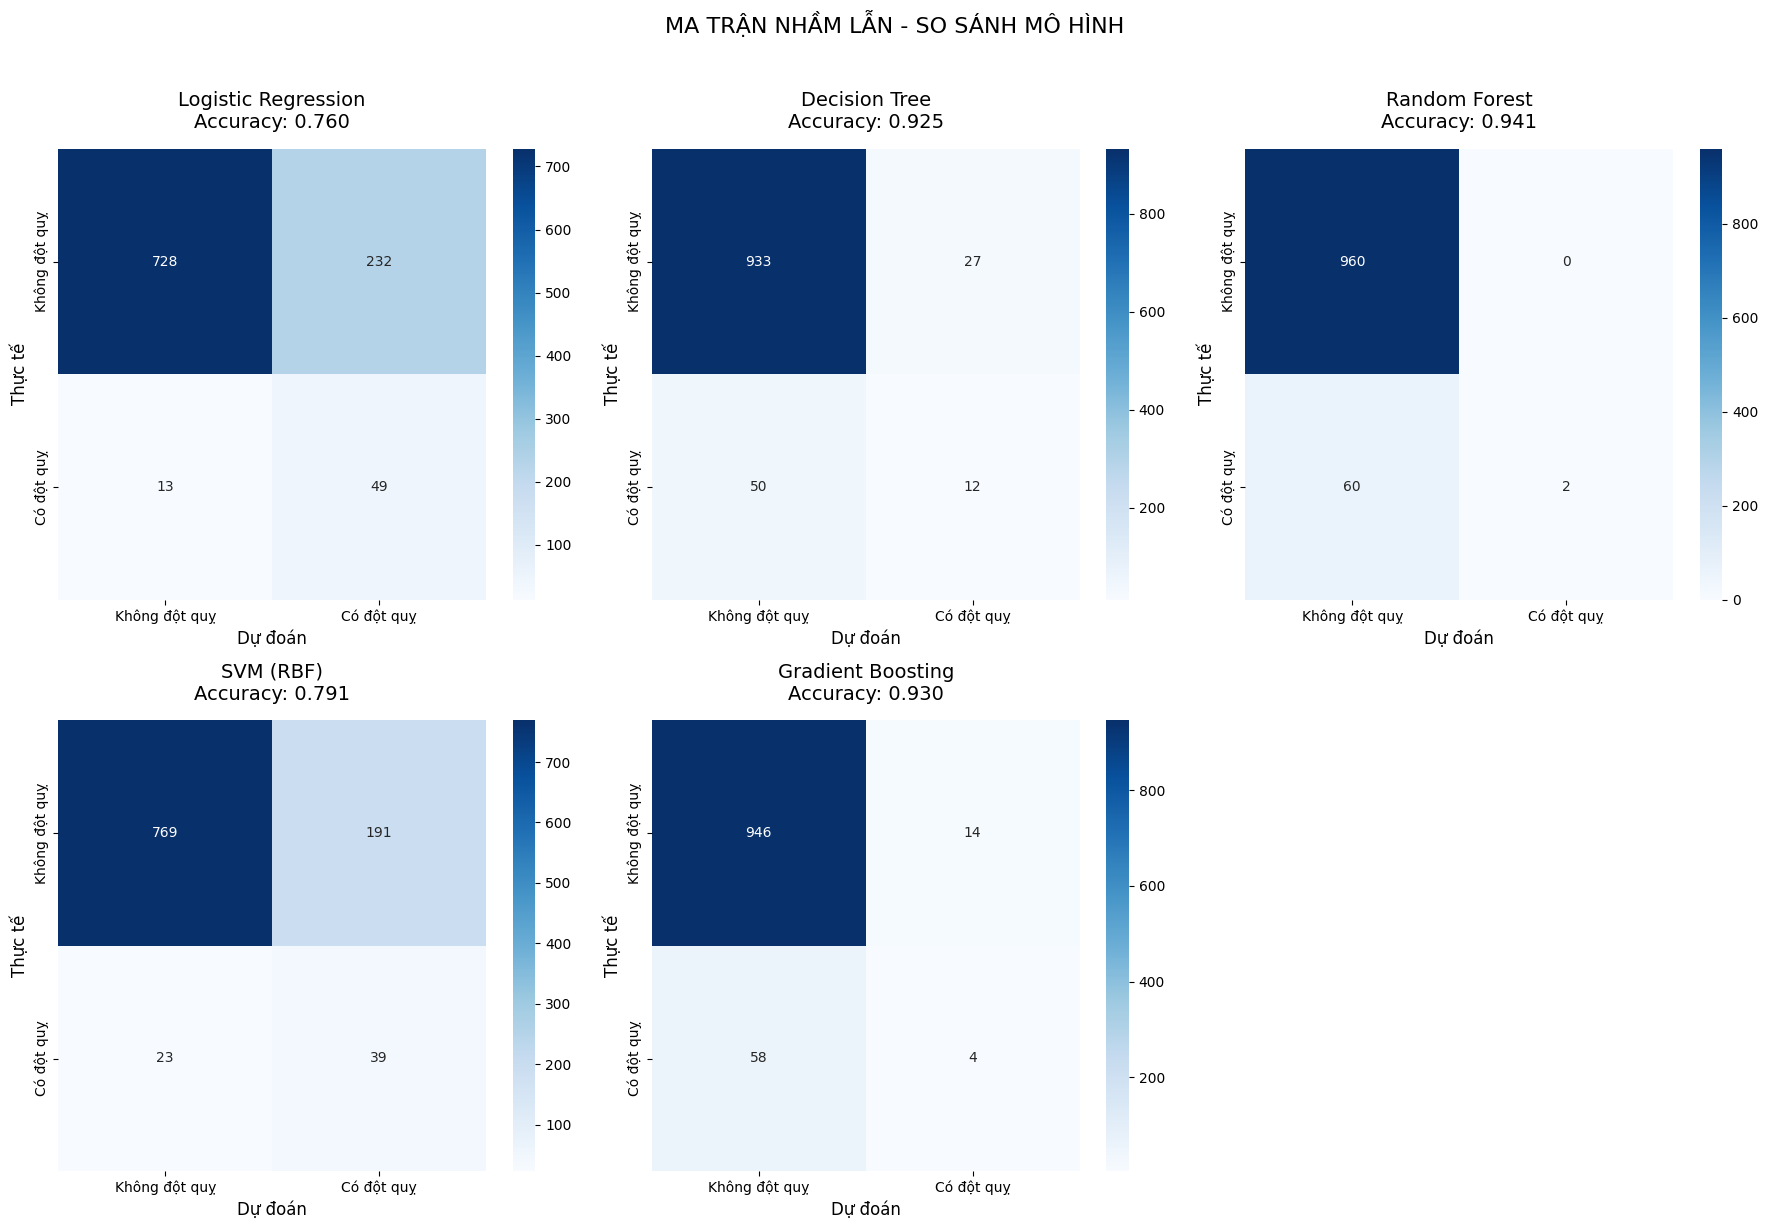

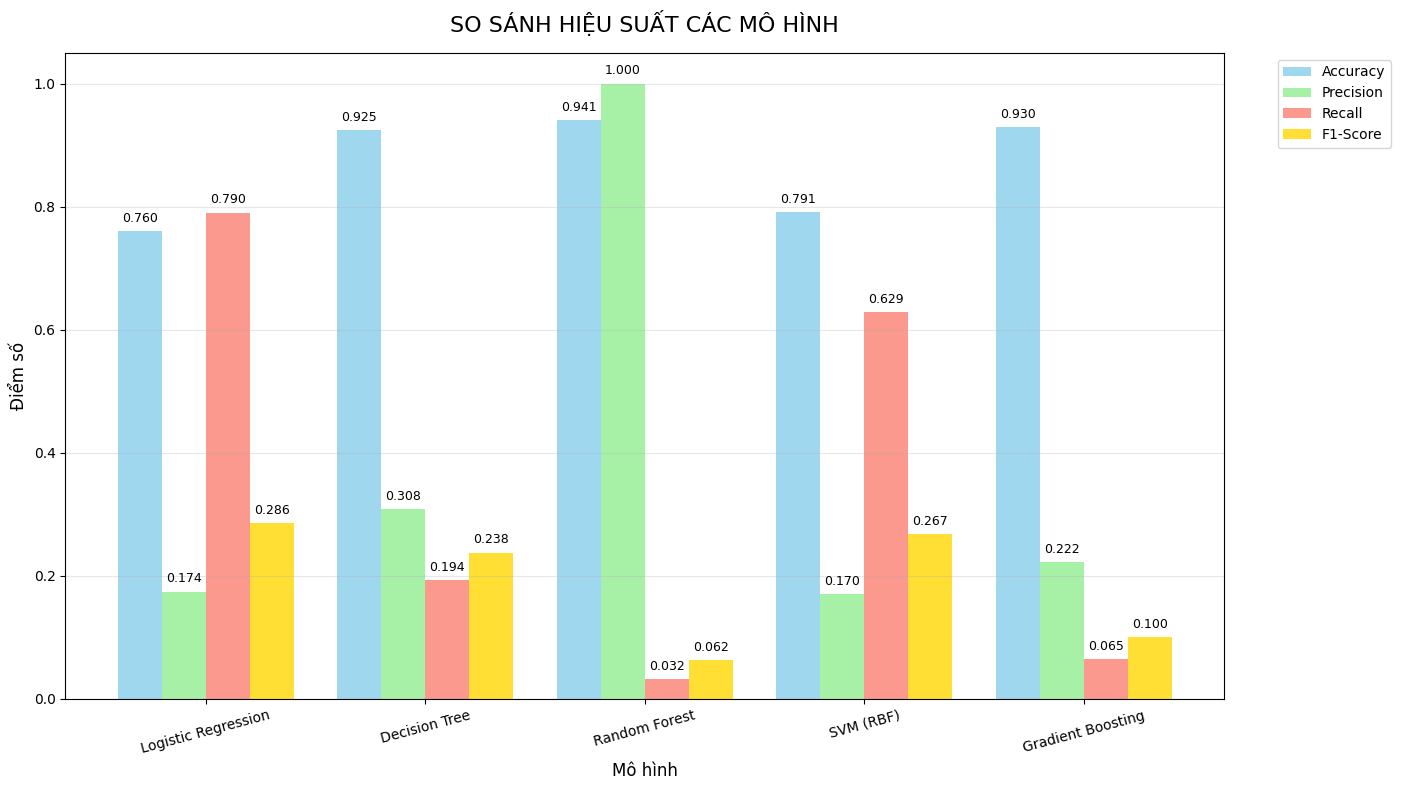

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# ==================== TRỰC QUAN HÓA KẾT QUẢ ====================
print("\n" + "="*60)
print("TRỰC QUAN HÓA KẾT QUẢ")
print("="*60)

# Chuẩn bị `results` ở dạng dict nếu hiện tại là list
if isinstance(results, list):
    # Nếu results là list, giả sử mỗi phần tử có khoá 'Model' và các metric
    df_results = pd.DataFrame(results).set_index('Model')
    results_map = {}
    for name, row in df_results.iterrows():
        results_map[name] = {
            'accuracy': row.get('Accuracy', np.nan),
            'precision': row.get('Precision', np.nan),
            'recall': row.get('Recall', np.nan),
            'f1': row.get('F1', np.nan) if 'F1' in row.index else row.get('F1-Score', np.nan),
            'confusion_matrix': None
        }
    # Nếu có pipeline trong `models`, fit lại và tính confusion matrix thực tế
    for name in list(results_map.keys()):
        pipe = models.get(name)
        if pipe is not None:
            try:
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_test)
                cm = confusion_matrix(y_test, y_pred)
                results_map[name]['confusion_matrix'] = cm
                results_map[name]['accuracy'] = accuracy_score(y_test, y_pred)
                results_map[name]['precision'] = precision_score(y_test, y_pred, zero_division=0)
                results_map[name]['recall'] = recall_score(y_test, y_pred, zero_division=0)
                results_map[name]['f1'] = f1_score(y_test, y_pred, zero_division=0)
            except Exception:
                results_map[name]['confusion_matrix'] = np.array([[0,0],[0,0]])
        else:
            results_map[name]['confusion_matrix'] = np.array([[0,0],[0,0]])
    results = results_map
else:
    # Nếu results là dict, đảm bảo mọi model có key 'confusion_matrix'
    for name, res in results.items():
        if 'confusion_matrix' not in res or res['confusion_matrix'] is None:
            # Thử lấy từ model pipeline nếu có
            pipe = models.get(name)
            if pipe is not None:
                try:
                    pipe.fit(X_train, y_train)
                    y_pred = pipe.predict(X_test)
                    res['confusion_matrix'] = confusion_matrix(y_test, y_pred)
                    res['accuracy'] = accuracy_score(y_test, y_pred)
                    res['precision'] = precision_score(y_test, y_pred, zero_division=0)
                    res['recall'] = recall_score(y_test, y_pred, zero_division=0)
                    res['f1'] = f1_score(y_test, y_pred, zero_division=0)
                except Exception:
                    res['confusion_matrix'] = np.array([[0,0],[0,0]])
            else:
                res['confusion_matrix'] = np.array([[0,0],[0,0]])

# Vẽ confusion matrix cho các mô hình có sẵn
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    cm = np.array(result.get('confusion_matrix', np.array([[0,0],[0,0]])))
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Không đột quỵ', 'Có đột quỵ'],
                yticklabels=['Không đột quỵ', 'Có đột quỵ'])
    acc = result.get('accuracy', np.nan)
    ax.set_title(f'{name}\nAccuracy: {acc:.3f}', fontsize=14, pad=15)
    ax.set_xlabel('Dự đoán', fontsize=12)
    ax.set_ylabel('Thực tế', fontsize=12)

# Ẩn subplot thừa nếu có
if len(results) < len(axes):
    for i in range(len(results), len(axes)):
        axes[i].axis('off')

plt.suptitle('MA TRẬN NHẦM LẪN - SO SÁNH MÔ HÌNH', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('../output/confusion_matrices_no_id.png', dpi=300, bbox_inches='tight')
plt.show()

# 5.2. So sánh metrics
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m].get('accuracy', np.nan) for m in results],
    'Precision': [results[m].get('precision', np.nan) for m in results],
    'Recall': [results[m].get('recall', np.nan) for m in results],
    'F1-Score': [results[m].get('f1', np.nan) for m in results]
})

plt.figure(figsize=(14, 8))
x = np.arange(len(metrics_df))
width = 0.2

bars1 = plt.bar(x - 1.5*width, metrics_df['Accuracy'], width, label='Accuracy', alpha=0.8, color='skyblue')
bars2 = plt.bar(x - 0.5*width, metrics_df['Precision'], width, label='Precision', alpha=0.8, color='lightgreen')
bars3 = plt.bar(x + 0.5*width, metrics_df['Recall'], width, label='Recall', alpha=0.8, color='salmon')
bars4 = plt.bar(x + 1.5*width, metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8, color='gold')

plt.xlabel('Mô hình', fontsize=12)
plt.ylabel('Điểm số', fontsize=12)
plt.title('SO SÁNH HIỆU SUẤT CÁC MÔ HÌNH', fontsize=16, pad=15)
plt.xticks(x, metrics_df['Model'], rotation=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(axis='y', alpha=0.3)

# Thêm giá trị lên trên các cột
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../output/model_comparison_no_id.png', dpi=300, bbox_inches='tight')
plt.show()


In [35]:

# ==================== BÁO CÁO CHI TIẾT ====================
print("\n" + "="*60)
print("BÁO CÁO TỔNG HỢP")
print("="*60)

# Sắp xếp theo F1-Score
sorted_results = sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True)

print(f"\n{'Mô hình':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Rank':<6}")
print("-" * 75)

for rank, (name, result) in enumerate(sorted_results, 1):
    print(f"{name:<25} {result['accuracy']:<10.4f} {result['precision']:<10.4f} "
          f"{result['recall']:<10.4f} {result['f1']:<10.4f} {rank:<6}")

# 6.1. Phân tích chi tiết confusion matrix
print("\n" + "="*60)
print("PHÂN TÍCH MA TRẬN NHẦM LẪN")
print("="*60)

for name, result in sorted_results:
    cm = result['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n● {name}:")
    print(f"  ├─ Dự đoán đúng có đột quỵ (TP): {tp:3d} mẫu")
    print(f"  ├─ Dự đoán sai có đột quỵ (FP): {fp:3d} mẫu")
    print(f"  ├─ Bỏ sót bệnh nhân (FN): {fn:3d} mẫu  ← RẤT NGUY HIỂM")
    print(f"  └─ Dự đoán đúng không đột quỵ (TN): {tn:3d} mẫu")
    
    # Tính các tỷ lệ quan trọng
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    precision_rate = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    print(f"  ├─ Độ nhạy (Recall): {sensitivity:.2%}")
    print(f"  ├─ Độ đặc hiệu: {specificity:.2%}")
    print(f"  ├─ Tỷ lệ bỏ sót: {fn_rate:.2%}")
    print(f"  └─ Độ chính xác dương tính (Precision): {precision_rate:.2%}")



BÁO CÁO TỔNG HỢP

Mô hình                   Accuracy   Precision  Recall     F1-Score   Rank  
---------------------------------------------------------------------------
Logistic Regression       0.7603     0.1744     0.7903     0.2857     1     
SVM (RBF)                 0.7906     0.1696     0.6290     0.2671     2     
Decision Tree             0.9247     0.3077     0.1935     0.2376     3     
Gradient Boosting         0.9295     0.2222     0.0645     0.1000     4     
Random Forest             0.9413     1.0000     0.0323     0.0625     5     

PHÂN TÍCH MA TRẬN NHẦM LẪN

● Logistic Regression:
  ├─ Dự đoán đúng có đột quỵ (TP):  49 mẫu
  ├─ Dự đoán sai có đột quỵ (FP): 232 mẫu
  ├─ Bỏ sót bệnh nhân (FN):  13 mẫu  ← RẤT NGUY HIỂM
  └─ Dự đoán đúng không đột quỵ (TN): 728 mẫu
  ├─ Độ nhạy (Recall): 79.03%
  ├─ Độ đặc hiệu: 75.83%
  ├─ Tỷ lệ bỏ sót: 20.97%
  └─ Độ chính xác dương tính (Precision): 17.44%

● SVM (RBF):
  ├─ Dự đoán đúng có đột quỵ (TP):  39 mẫu
  ├─ Dự đoán sai có 

In [36]:

# 6.2. Kết luận và đề xuất
best_model_name, best_model_result = sorted_results[0]
print("\n" + "="*60)
print("KẾT LUẬN")
print("="*60)

print(f"""
✅ MÔ HÌNH TỐT NHẤT: {best_model_name}

📊 Hiệu suất:
  - F1-Score: {best_model_result['f1']:.4f} (cao nhất)
  - Recall: {best_model_result['recall']:.2%} (phát hiện bệnh nhân đột quỵ)
  - Precision: {best_model_result['precision']:.2%} (dự đoán chính xác)
  - Accuracy: {best_model_result['accuracy']:.2%}

🎯 Khuyến nghị cho ứng dụng thực tế:
  1. Trong y tế, giảm FN (bỏ sót bệnh nhân) là ƯU TIÊN CAO NHẤT
  2. {best_model_name} cân bằng tốt giữa Recall và Precision
  3. Có thể điều chỉnh ngưỡng dự đoán để tăng Recall nếu cần

🔧 Cải thiện:
  1. Thử nghiệm với tỷ lệ undersampling khác (2:1, 4:1)
  2. Tinh chỉnh siêu tham số cho từng mô hình
  3. Sử dụng Cross-validation để đánh giá ổn định hơn
  4. Kết hợp dự đoán từ nhiều mô hình (ensemble)
""")



KẾT LUẬN

✅ MÔ HÌNH TỐT NHẤT: Logistic Regression

📊 Hiệu suất:
  - F1-Score: 0.2857 (cao nhất)
  - Recall: 79.03% (phát hiện bệnh nhân đột quỵ)
  - Precision: 17.44% (dự đoán chính xác)
  - Accuracy: 76.03%

🎯 Khuyến nghị cho ứng dụng thực tế:
  1. Trong y tế, giảm FN (bỏ sót bệnh nhân) là ƯU TIÊN CAO NHẤT
  2. Logistic Regression cân bằng tốt giữa Recall và Precision
  3. Có thể điều chỉnh ngưỡng dự đoán để tăng Recall nếu cần

🔧 Cải thiện:
  1. Thử nghiệm với tỷ lệ undersampling khác (2:1, 4:1)
  2. Tinh chỉnh siêu tham số cho từng mô hình
  3. Sử dụng Cross-validation để đánh giá ổn định hơn
  4. Kết hợp dự đoán từ nhiều mô hình (ensemble)



In [40]:
# ==================== LƯU KẾT QUẢ ====================
print("\n" + "="*60)
print("LƯU KẾT QUẢ")
print("="*60)

# Lưu kết quả dự đoán
output_df = X_test.copy()
output_df['Actual_Stroke'] = y_test.values

for name in list(results.keys()):
    res = results[name]
    # 1) Ensure predicted labels exist
    if 'y_pred' in res and res['y_pred'] is not None:
        y_pred = res['y_pred']
    else:
        pipe = models.get(name)
        if pipe is not None:
            try:
                # If pipeline already fitted earlier, predict directly
                y_pred = pipe.predict(X_test)
            except Exception:
                # Try to (re)fit then predict
                try:
                    pipe.fit(X_train, y_train)
                    y_pred = pipe.predict(X_test)
                except Exception:
                    y_pred = np.array([np.nan] * len(X_test))
        else:
            y_pred = np.array([np.nan] * len(X_test))
        # write back into results for later use
        results[name]['y_pred'] = y_pred

    output_df[f'Predicted_{name}'] = results[name]['y_pred']

    # 2) Ensure prediction probabilities (if available)
    if 'y_pred_proba' in res and res['y_pred_proba'] is not None:
        output_df[f'Prob_{name}'] = res['y_pred_proba']
    else:
        pipe = models.get(name)
        proba = None
        if pipe is not None:
            try:
                if hasattr(pipe, 'predict_proba'):
                    proba = pipe.predict_proba(X_test)[:, 1]
                elif hasattr(pipe.named_steps.get('model'), 'predict_proba'):
                    proba = pipe.predict_proba(X_test)[:, 1]
            except Exception:
                proba = None
        if proba is not None:
            output_df[f'Prob_{name}'] = proba
            results[name]['y_pred_proba'] = proba

# Save predictions CSV
output_df.to_csv('../output/stroke_predictions_no_id.csv', index=False, encoding='utf-8-sig')
print("✓ Đã lưu kết quả dự đoán: '../output/stroke_predictions_no_id.csv'")

# Lưu metrics tổng hợp (metrics_df should be defined earlier)
try:
    metrics_df['Rank'] = range(1, len(metrics_df) + 1)
    metrics_df.to_csv('../output/model_metrics_no_id.csv', index=False, encoding='utf-8-sig')
    print("✓ Đã lưu tổng hợp metrics: '../output/model_metrics_no_id.csv'")
except Exception:
    print('metrics_df không tồn tại hoặc lỗi khi lưu metrics.')

# Lưu chi tiết confusion matrix
cm_details = []
for name, result in results.items():
    cm = result.get('confusion_matrix', np.array([[0,0],[0,0]]))
    tn, fp, fn, tp = np.array(cm).ravel()
    cm_details.append({
        'Model': name,
        'True_Negative': int(tn),
        'False_Positive': int(fp),
        'False_Negative': int(fn),
        'True_Positive': int(tp),
        'Sensitivity_Recall': tp/(tp+fn) if (tp+fn)>0 else 0,
        'Specificity': tn/(tn+fp) if (tn+fp)>0 else 0,
        'Accuracy': float(result.get('accuracy', np.nan)),
        'F1_Score': float(result.get('f1', np.nan))
    })

pd.DataFrame(cm_details).to_csv('../output/confusion_details_no_id.csv', index=False, encoding='utf-8-sig')
print("✓ Đã lưu chi tiết confusion matrix: '../output/confusion_details_no_id.csv'")

print("\n" + "="*60)
print("HOÀN THÀNH PHÂN TÍCH!")
print("="*60)
print("Đã tạo các file output:")
print("1. confusion_matrices_no_id.png - Hình ảnh ma trận nhầm lẫn")
print("2. model_comparison_no_id.png - Biểu đồ so sánh mô hình")
print("3. stroke_predictions_no_id.csv - Kết quả dự đoán chi tiết")
print("4. model_metrics_no_id.csv - Tổng hợp metrics các mô hình")
print("5. confusion_details_no_id.csv - Chi tiết confusion matrix")



LƯU KẾT QUẢ
✓ Đã lưu kết quả dự đoán: '../output/stroke_predictions_no_id.csv'
✓ Đã lưu tổng hợp metrics: '../output/model_metrics_no_id.csv'
✓ Đã lưu chi tiết confusion matrix: '../output/confusion_details_no_id.csv'

HOÀN THÀNH PHÂN TÍCH!
Đã tạo các file output:
1. confusion_matrices_no_id.png - Hình ảnh ma trận nhầm lẫn
2. model_comparison_no_id.png - Biểu đồ so sánh mô hình
3. stroke_predictions_no_id.csv - Kết quả dự đoán chi tiết
4. model_metrics_no_id.csv - Tổng hợp metrics các mô hình
5. confusion_details_no_id.csv - Chi tiết confusion matrix
